# 8. Защита проекта: 
## А/Б-тестирование по данным НКО "Если быть точным"

**КРИТЕРИИ ОЦЕНИВАНИЯ ПРЕЗЕНТАЦИИ:

1. Мы доступно объяснили, какие шаги были предприняты во время подведения итогов и почему.
2. Наши объяснения апеллируют к бизнесу, а не к математике: не «уменьшение дисперсии», а «сокращение времени теста».
3. Покрыты основные придуманные гипотезы, их причины и выбор той гипотезы, которая будет проверяться.
4. Объяснён дизайн эксперимента и причины тех или иных характеристик (размер выборки, время теста и прочее).
5. Сделан ясный вывод об успешности или неуспешности гипотезы, приведены рекомендации по масштабированию.
6. Есть визуализация данных, на основе которых принимались решения, и визуализация результатов.
7. Проведена оценка эффекта функционала и её объяснение при масштабировании эксперимента на всю аудиторию, если тест успешен.

### АНАЛИЗ ДАННЫХ:

In [1]:
# Загружаем необходимые библиотеки:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# Получаем необходимые данные:
data = pd.read_csv('PA_15_ab_test_results.csv')

In [3]:
# Смотрим общую информацию о данных:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Day Index            28 non-null     object
 1   Users                28 non-null     int64 
 2   Email Subscriptions  28 non-null     int64 
 3   Group Type           28 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.0+ KB


In [4]:
data.head()

,Day Index,Users,Email Subscriptions,Group Type
0,08/07/20,170,1,control
1,08/07/20,142,3,test
2,09/07/20,100,1,control
3,09/07/20,95,5,test
4,10/07/20,170,2,control


### ИЗУЧЕНИЕ КЛЮЧЕВОЙ МЕТРИКИ:

In [5]:
# Посмотрим на распределение среднего количества подписок в переменной 'x':
data_dist = data.reset_index()

In [6]:
# Очистим от нулевых значений:
data_dist = data_dist[data_dist['Email Subscriptions'] > 0]

<AxesSubplot:>

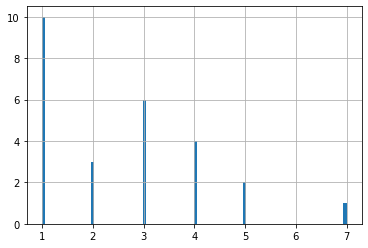

In [7]:
data_dist.groupby('index')['Email Subscriptions'].sum().hist(bins = 100)

Видим, что распределение среднего количества подписок ненормальное.

In [8]:
# Группируем данные по типу группы, в разрезе пользователей и подписчиков:
data.groupby(['Group Type']).sum()

,Users,Email Subscriptions
Group Type,,
control,2476,18
test,2663,49


In [9]:
# Смотрим на первоначальное значение среднего количества подписок:
print(round(data.groupby('Group Type')['Email Subscriptions'].sum(), 2))

Group Type
control    18
test       49
Name: Email Subscriptions, dtype: int64


In [10]:
# Задаём переменные для пользователей, подписчиков и конверсии из пользователей в подписчиков для тестовой группы:

test_subscribers = data[data['Group Type'] == 'test']['Email Subscriptions'].sum()
print('test subscribers: {}'.format(test_subscribers))

test_users = data[data['Group Type'] == 'test']['Users'].sum()
print('test users: {}'.format(test_users))

test_conversion = test_subscribers / test_users
print('test, subscribers to users conversion: {}'.format(test_conversion))

test subscribers: 49
test users: 2663
test, subscribers to users conversion: 0.01840030041306797


In [11]:
# Задаём переменные для пользователей, подписчиков и конверсии из пользователей в подписчиков для контрольной группы:

control_subscribers = data[data['Group Type'] == 'control']['Email Subscriptions'].sum()
print('control subscribers: {}'.format(control_subscribers))

control_users = data[data['Group Type'] == 'control']['Users'].sum()
print('control users: {}'.format(control_users))

control_conversion = control_subscribers / control_users
print('control, subscribers to users conversion: {}'.format(control_conversion))

control subscribers: 18
control users: 2476
control, subscribers to users conversion: 0.007269789983844911


In [12]:
# Считаем отношение конверсии тестовой к контрольной группе:
test_to_control_conversion = test_conversion / control_conversion
round(test_to_control_conversion, 2)

2.53

##### Здесь, мы видим, что отношение конверсии пользователей в подписчиков в тестовой группе в сравнении с контрольной выросло в 2.53 раза, что может говорить об эффективности тестируемой гипотезы.

In [13]:
# Добавляем столбец с конверсией:
data['conversion'] = data['Email Subscriptions'] / data['Users']

##### для проверки значимости разницы конверсии используется Z-тест

##### Устанавливаем библиотеку с множеством разных статистических функций, в том числе и Z-тест:

In [14]:
# Загружаем библиотеку statsmodels для проведения статистических тестов:

!pip install statsmodels

Теперь для теста устанавливаем следующие условия:

Нулевая гипотеза: нет никакой разницы в конверсии между контрольной и тестовой группой.
Альтернативная гипотеза: тестовая группа даёт значимо большую конверсию, чем контрольная.
За α возьмём стандартное значение в 0.05.

##### Применяем Z-test:

In [15]:
from statsmodels.stats.weightstats import ztest

In [16]:
print(ztest(data[data['Group Type'] == 'control']['conversion'], data[data['Group Type'] == 'test']['conversion']))

(-3.053352894266018, 0.002262996434753332)


In [17]:
statistic, p_value = ztest(data[data['Group Type'] == 'control']['Email Subscriptions'].values,
                           data[data['Group Type'] == 'test']['Email Subscriptions'].values)

print(f"statistic: {statistic}")
print(f"p_value: {p_value}")

statistic: -4.485259450125895
p_value: 7.28252648334219e-06


In [18]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

In [19]:
count = np.array([18, 49])
nobs = np.array([2476, 2663])
stats, p_value = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(p_value))

0.000


##### При подсчёте статистической значимости полученной разницы с помощью Z-test, получаем значение p-value равное 0, что меньше уровня значимости 5%.

### ТЕСТИРОВАНИЕ ПОДХОДА БУТСТРЭП-СЭМПЛИРОВАНИЯ + ВИЗУАЛИЗАЦИЯ

100%|██████████| 10000/10000 [00:01<00:00, 6848.72it/s]


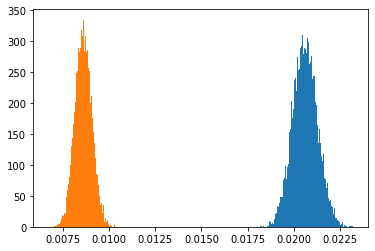

In [20]:
# Проводим бутстреп-сэмплирование для тестовой и контрольной группы:

%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm

np.random.seed(1)
all_values_test = data[data['Group Type'] == 'test']['conversion'].values.tolist()
all_values_control = data[data['Group Type'] == 'control']['conversion'].values.tolist()

sample_mean_test = []
sample_mean_control = []

for i in tqdm(range(10000)):
    sample_n = np.random.choice(all_values_test, size = 300)
    sample_mean_test.append(sample_n.mean())
    
    sample_n = np.random.choice(all_values_control, size = 300)
    sample_mean_control.append(sample_n.mean())

plt.hist(sample_mean_test, bins = 100)
plt.hist(sample_mean_control, bins = 100)
plt.show()

In [21]:
print(f"Control 95 percentile: {np.percentile(sample_mean_control, 95)}")
print(f"Test 5 percentile: {np.percentile(sample_mean_test, 5)}")

Control 95 percentile: 0.009364658304221613
Test 5 percentile: 0.019513732416127888


##### На графике слева видим, что 5 и 95 квантили (синяя - тестовая и оранж. - контрольная группа, соответственно) не перекрываются, а значит есть статистически значимая разница по среднему количеству подписок в двух группах.
Согласно предварительным результатам, если 95 персентиль у контрольного распределения меньше, чем 5 персентиль у тестового распределения - это говорит о том, что разность между ними статистически значимая на уровне значимости 0.95. Таким образом, мы отвергаем нулевую гипотезу о том, что распределение нормальное и поэтому считаем наш эксперимент тестируемой гипотезы успешным.

100%|██████████| 10000/10000 [00:01<00:00, 6431.39it/s]


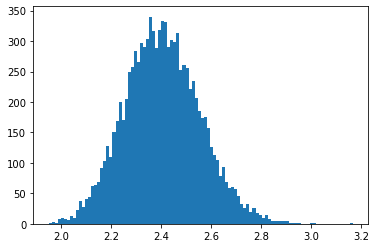

2.1223183381475184 2.713495810931861


In [22]:
# Вычисляем 95% доверительный интервал для полученного значения конверсии тестовой группы через бутстрэп-сэмплирование.
# Генерируем 300 случайных подвыборок, с помощью сэмплируемых итераций в 10000 раз.

np.random.seed(1)
all_values_test = data[data['Group Type'] == 'test']['conversion'].values.tolist()
all_values_control = data[data['Group Type'] == 'control']['conversion'].values.tolist()

sample_mean_ratio = []

for i in tqdm(range(10000)):
    sample_test = np.random.choice(all_values_test, size = 300)
    sample_control = np.random.choice(all_values_control, size = 300)
    sample_mean_ratio.append(sample_test.mean() / sample_control.mean())
    
plt.hist(sample_mean_ratio, bins = 100)
plt.show()
print(np.percentile(sample_mean_ratio, 2.5), np.percentile(sample_mean_ratio, 97.5))

Считаем межквартильный размах - разницу между крайними значениями у 95% доверительного интервала, с помощью калькулятора >>> https://sample-size.net/confidence-interval-proportion/:

N = 2663 (Sample size)
X = 49 (Number in the sample with the result or finding in question)
CL = 95% (Confidence level)

1. Binomial "exact" calculation
Proportion of positive results = P = x/N = 0.0184
Lower bound = 0.0136
Upper bound = 0.0243

Размах = Upper bound - Lower bound = 0.0243 - 0.0136 = 0.0107

Вычисляем 95% доверительный интервал для полученного значения конверсии тестовой группы. Считаем какой получился размах между крайними значениями, с помощью калькулятора >>> https://sample-size.net/confidence-interval-proportion/

Размах между значениями равен 0.0107 на уровне доверия 95%.
Мы можем считать проверяемую гипотезу успешной.

In [23]:
print(round(data.groupby('Day Index')['Email Subscriptions'].sum().mean(), 2))

4.79


In [24]:
data_group = data.groupby(['Group Type']).sum().reset_index()
data_group

,Group Type,Users,Email Subscriptions,conversion
0,control,2476,18,0.120338
1,test,2663,49,0.288824


In [25]:
data_group['Users'][0]

2476

### ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True) 
cf.go_offline()

Text(0.5, 1.0, 'Количество Подписчиков, в контрольной и тестовой группе')

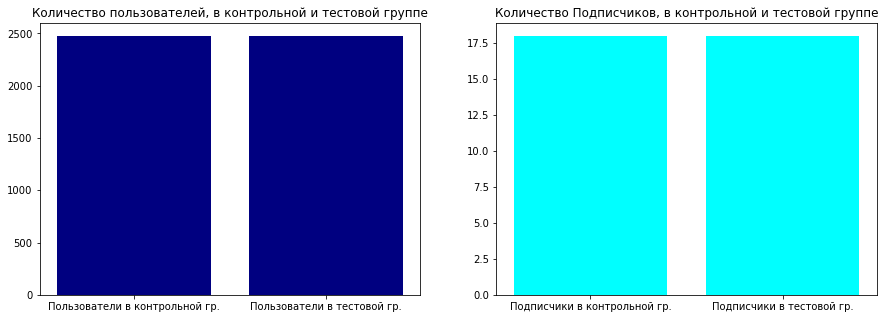

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0].bar(x = 'Пользователи в контрольной гр.', height = data_group['Users'][0], color = 'navy')
axes[0].bar(x = 'Пользователи в тестовой гр.', height = data_group['Users'][0], color = 'navy')
axes[0].set_title('Количество пользователей, в контрольной и тестовой группе')

axes[1].bar(x = 'Подписчики в контрольной гр.', height = data_group['Email Subscriptions'][0], color = 'aqua')
axes[1].bar(x = 'Подписчики в тестовой гр.', height = data_group['Email Subscriptions'][0], color = 'aqua')
axes[1].set_title('Количество Подписчиков, в контрольной и тестовой группе')

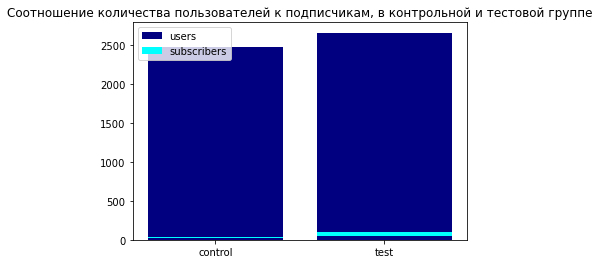

In [27]:
index = np.arange(2)
plt.title('Соотношение количества пользователей к подписчикам, в контрольной и тестовой группе')
plt.bar(index, control_users, color = 'navy')
plt.bar(index, control_subscribers, color = 'aqua', bottom = control_subscribers)
plt.bar(index[1], test_users, color = 'navy')
plt.bar(index[1], test_subscribers, color = 'aqua', bottom = test_subscribers)
plt.xticks(index, ['control', 'test'])
plt.legend(['users', 'subscribers'])
plt.show()

ВЫВОД:
В результате данной визуализации, также видим, что количество подписчиков в тестовой группе: 49 больше, чем в контрольной: 18
Таким образом, конверсия из пользователей в подписчиков в тестовой группе по сравнению с контрольной группой выросла в 2.53 раза, а прирост среднего количества подписок составляет значение в диапазоне от 2.122 до 2.713 раз, с вероятностью 95% - подтверждаем, что эксперимент успешный.